Загружаем и обрабатываем исзодные данные

In [81]:
file_obj = open('products_sentiment_train.tsv')
test_file_obj = open('products_sentiment_test.tsv')

In [82]:
def generate_text_and_targets(file_obj):
    data = [line.strip() for line in file_obj.readlines()]
    targets = [int(sentence[-1]) for sentence in data]
    sentences = [sentence[:-1].strip() for sentence in data]
    return sentences, targets

def generate_text(test_file_obj):
    data = [line.strip() for line in test_file_obj.readlines()][1:]
    sentences = [line[len(str(num)):].strip() for num, line in enumerate(data)]
    return sentences

In [83]:
train_sentences, targets = generate_text_and_targets(file_obj)
test_sentences = generate_text(test_file_obj)

Загружаем библиотеки. Выбранная архитектура приведена ниже.

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
scores = cross_val_score(Pipeline([('vectorizer', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 6), stop_words='english',
                                                                  min_df=4)), 
                                   ('classifier', LogisticRegression())]), train_sentences, targets, cv=5, scoring='accuracy')
print(scores.mean())

0.786


Выберем порог бинаризации на основании roc auc

In [86]:
classifier = Pipeline([('vectorizer', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 6), stop_words='english', min_df=4)), 
                        ('classifier', LogisticRegression())])

(600, 2)
600


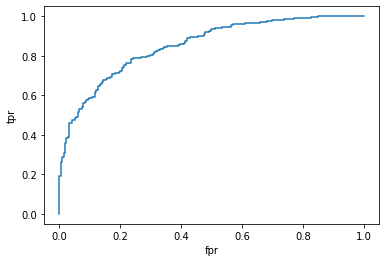

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(train_sentences, targets, test_size=0.3)

classifier.fit(X_train, y_train)
predict_probs = classifier.predict_proba(X_test)
print(predict_probs.shape)
print(len(y_test))

fpr, tpr, thr = roc_curve(y_test, predict_probs[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

Предсказания на основе нового порога бинаризации

In [88]:
def treshold(y, probs):
  fpr, tpr, thr = roc_curve(y, probs)
  distances = [math.sqrt(math.pow(fp - 0, 2) + math.pow(tp - 1, 2)) for fp, tp in zip(fpr, tpr)]
  return thr[distances.index(min(distances))]

In [89]:
import math

treshold = treshold(y_test, predict_probs[:, 1])
treshold

0.6132742441758616

In [90]:
def predict_test(t, text):
  classifier.fit(train_sentences, targets)
  test_probs = classifier.predict_proba(text)
  adjusted_preds = [0 if x < t else 1 for x in test_probs[:, 1]]
  return adjusted_preds

predictions = predict_test(treshold, test_sentences)
len(predictions)

500

Загрузка предсказаний в csv файл

In [115]:
import pandas as pd

predictions_df = pd.DataFrame(predictions, columns=['y'])
predictions_df.index.name = 'Id'
predictions_df.to_csv('predictions_tfidf.csv')

#BERT

Во избежании проведения кросс-валидации для нахождения нужной комбинации гиперпараметров для tfidf, можно воспользоваться более продвинутой архитектурой для предсказания тональности, называемой BERT. BERT основана на использовании архитектуры attention. Тенсор, извлекаемый из последнего слоя attention первого токена, проганяется через линный слой с двумя нейронами, которые подсоединяются к слою softmax. Мы будем пользоваться библиотекой transformers с pretrained эмбеддингами, токенизатором и моделью, рассчитанной на два класса. Для построения модели используется pytorch. Для ускорения вычислений, нижепреведенный код можно запустить в colab с gpu кернелом.

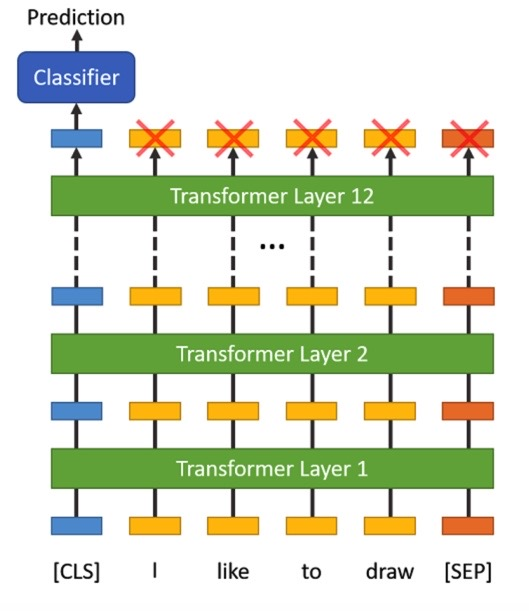

In [91]:
!pip install transformers #only in colab
import torch
import transformers
from transformers import BertTokenizer

In [92]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('device name:', torch.cuda.get_device_name(0))

device name: Tesla K80


Пользуемя pretrained токенизатором

In [93]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [94]:
def find_length(sentences):
  return max([len(tokenizer.encode(sent)) for sent in sentences])

In [95]:
train_seq_length = find_length(train_sentences) #without special tokens
train_seq_length #let length be 120

113

Все токенизированные последовательности должны быть приведены к общей длине при помощи токена ['PAD']. Также к последовательностям должны быть добавлены токены '[CLS]' и '[SEP]' в начале и конце (до паддинга). Функция encode_plus возвращает токенизированные последовательности со специальными токенами и attention masks, имеющие такую же форму, как и получаемый тенсор токенизированных последовательностей и состоящий из 1 и 0, где 0 соответсвует токену ['PAD'], 1 - всем остальным.

In [96]:
def return_ids_masks(sentences):
  input_ids = []
  attention_masks = []

  for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [97]:
train_ids, train_masks = return_ids_masks(train_sentences)
targets = torch.tensor(targets)

Создаем датасеты для тренировки и валидации

In [98]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(train_ids, train_masks, targets)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Создаем Dataloaders для тренировки и валидации

In [99]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Загружаем модель

In [100]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Тренировочный алгоритм - AdamW (модификация градиентого спуска)

In [101]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Применеям learning rate scheduling

In [102]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Функция для вычисление accuracy на одном пакете

In [103]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

 Фунция для форматирования времени

In [104]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Файнтюним pretrained модель на двух эпохах. Валидация происходит в конце каждой эпохи.

In [105]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')
  t0 = time.time()

  total_train_loss = 0

  model.train()
  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    total_train_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  print("")
  print("Running Validation...")

  t0 = time.time()
  model.eval()

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
      (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
      
    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)

  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  avg_val_loss = total_eval_loss / len(validation_dataloader)

  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
  )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))





======== Epoch 1 / 2 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:46.

  Average training loss: 0.48
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.25
  Validation took: 0:00:03

Training complete!
Total training took 0:01:07 (h:mm:ss)

======== Epoch 2 / 2 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:46.

  Average training loss: 0.23
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.22
  Validation took: 0:00:03

Training complete!
Total training took 0:02:15 (h:mm:ss)


Выводи метрики

In [106]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.25,0.92,0:01:05,0:00:03
2,0.23,0.22,0.92,0:01:05,0:00:03


Dataloader для тестовых данных

In [111]:
test_ids, test_masks = return_ids_masks(test_sentences)

batch_size = 32

test_data = TensorDataset(test_ids, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Функция для вычисления вероятностей при использовании готовой модели. is_probs - выводим вероятности вместо меток классов. is_targets - дополнительно выводим ответы (например для валидационного набора).

In [143]:
def predict(loader, is_probs=False, is_targets=False):
  model.eval()
  predictions = []
  probabilities = [] #
  targets = []
  softmax = torch.nn.Softmax(dim=1)

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      logits = model(batch[0], token_type_ids=None, 
                  attention_mask=batch[1])
      
      predictions.append(torch.argmax(logits[0], dim=1).detach().cpu().numpy())

      if is_probs:
        probs = softmax(logits[0]).detach().cpu().numpy()
        probabilities.append(probs)
        if is_targets:
          targets.append(batch[2].to('cpu').numpy())

  if is_probs and not is_targets:
    return np.concatenate(probabilities, axis=0)
  elif is_probs and is_targets:
    return np.concatenate(probabilities, axis=0), np.concatenate(targets)
  else:
    return np.concatenate(predictions)

Фунция для вычисления вероятностей на основе нового порога бинаризации.

In [ ]:
def treshold(y, probs):
  fpr, tpr, thr = roc_curve(y, probs)
  distances = [math.sqrt(math.pow(fp - 0, 2) + math.pow(tp - 1, 2)) for fp, tp in zip(fpr, tpr)]
  return thr[distances.index(min(distances))]

Выбираем порог бинаризации по валидационной выборке

In [178]:
val_probs, val_targets = predict(validation_dataloader, is_probs=True, is_targets=True)

In [179]:
def treshold(targets, probs):
  fpr, tpr, thr = roc_curve(targets, probs[:, 1])
  distances = [math.sqrt(math.pow(fp - 0, 2) + math.pow(tp - 1, 2)) for fp, tp in zip(fpr, tpr)]
  treshold = thr[distances.index(min(distances))]
  return treshold

In [180]:
t = treshold(val_targets, val_probs)
t

0.33443928

In [181]:
def adjusted_preds(treshold, probs):
  return [0 if prob < t else 1 for prob in probs[:, 1]]

In [182]:
test_probs = predict(test_dataloader, is_probs=True)
adjusted_predictions = adjusted_preds(t, test_probs)
len(adjusted_predictions)

500

In [183]:
predictions_df = pd.DataFrame(adjusted_predictions, columns=['y'])
predictions_df.index.name = 'Id'

In [184]:
predictions_df.to_csv('adjusted_predictions_df_bert.csv')

Предсазания без бинаризации

In [185]:
test_probs = predict(test_dataloader)
len(test_probs)

500

In [186]:
predictions_df = pd.DataFrame(test_probs, columns=['y'])
predictions_df.index.name = 'Id'

In [187]:
predictions_df.to_csv('not_adjusted_predictions_df_bert.csv')

Порог бинаризации по всем данным

In [193]:
all_data_dataloader = DataLoader(
            dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [194]:
alldata_probs, alldata_targets = predict(all_data_dataloader, is_probs=True, is_targets=True)

In [195]:
t = treshold(alldata_targets, alldata_probs)
t

0.74690425

In [196]:
test_probs = predict(test_dataloader, is_probs=True)
adjusted_predictions_all = adjusted_preds(t, test_probs)
len(adjusted_predictions)

500

In [197]:
predictions_df = pd.DataFrame(adjusted_predictions_all, columns=['y'])
predictions_df.index.name = 'Id'

In [198]:
predictions_df.to_csv('allset_adjusted_predictions_df_bert.csv')

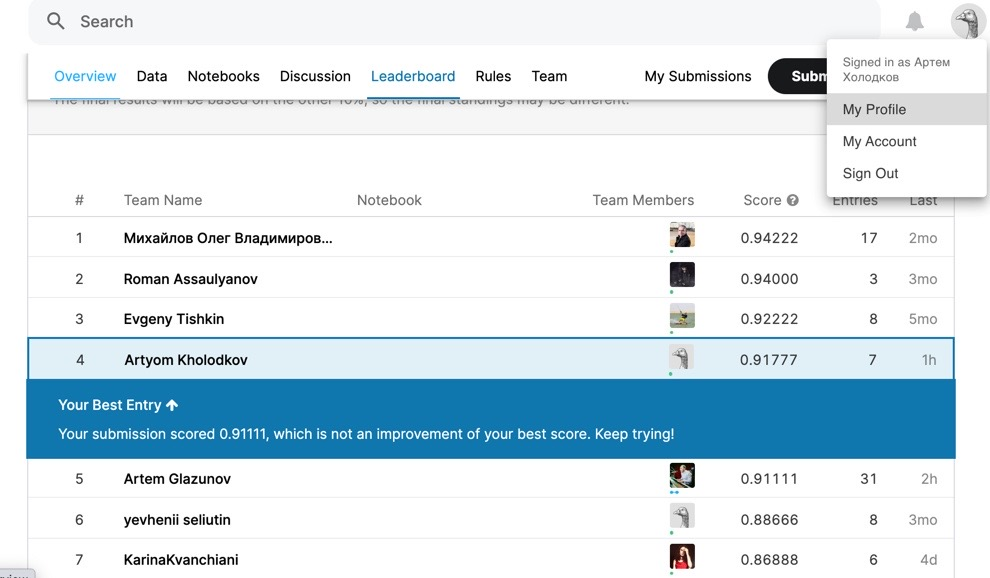